# Chapter 10

## Example 10.2

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict

In [63]:
class AccessControl:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    def __init__(self, k, p):
        self.k = k
        self.p = p
        self.actions = ['a', 'r']
    
    def start(self):
        self.state = self.getCustomer(), np.random.randint(0, self.k+1)
        return self.state
    
    def getCustomer(self):
        return 2**np.random.randint(0,4)
    
    def act(self, action):
        next_customer = self.getCustomer()
        freed_server = np.random.binomial(self.k - self.state[1], self.p)
        if self.state[1] == 0:
            self.state = next_customer, freed_server
            return self.state, 0, False
        else:
            if action == 'a':
                free_server = self.state[1] - 1 + freed_server
                reward = self.state[0]
                self.state = next_customer, free_server
                return self.state, reward, False
            else:
                self.state = next_customer, self.state[1] + freed_server
                return self.state, 0, False
    

In [64]:
access_control = AccessControl(10, 0.06)

In [65]:
class DSGSarsa():
    # differential semi-gradient sarsa
    def __init__(self, env, alpha, beta, epsilon, feature_length, state_action_function):
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.state_action_function = state_action_function # we assume state function is linear
        self.theta = np.zeros(feature_length)
        self.average_reward = 0
        self.actions = env.actions
        self.env = env
        self.state = env.start()
        self.action = np.random.choice(self.actions)
        self.timestep = 0
        
    def select_action(self, state, e_greedy=True):
        if e_greedy and np.random.uniform() < self.epsilon:
            return np.random.choice(self.actions)
        best_q = -100000
        best_action = None
        for action in self.actions:
            features = self.state_action_function(state, action)
            q = np.dot(features, self.theta)
            if q > best_q:
                best_q = q
                best_action = action
        return best_action
            
    
    def train(self, timesteps):
        while self.timestep < timesteps:
            next_state, reward, _ = self.env.act(self.action)
            features = self.state_action_function(self.state, self.action)
            next_action = self.select_action(next_state)
            next_features = self.state_action_function(next_state, next_action)
            td_error = reward - self.average_reward + np.dot(next_features, self.theta) - np.dot(features, self.theta)
            self.average_reward += self.beta * td_error
            self.theta += self.alpha * td_error * features # assume linear function, thus grad q = features
            self.state = next_state
            self.action = next_action
            self.timestep += 1

In [88]:
def get_state_action_function(no_of_priority, k, no_of_action):
    def state_action_function(state, action):
        priority = int(np.log2(state[0]))
        free_server = state[1]
        act = 0 if action == 'a' else 1
        features = np.zeros(no_of_priority * no_of_action * (k + 1))
        index = priority * (k+1) * no_of_action + (free_server * no_of_action) + act
        features[index] = 1
        return features
    return state_action_function

In [89]:
agent = DSGSarsa(access_control, 0.01, 0.01, 0.1, 11 * 4 * 2, get_state_action_function(4, 10, 2))

In [96]:
agent.train(2000000)

In [97]:
agent.average_reward

2.6626568119687368

In [98]:
policy = [[agent.select_action((priority, free), False) for free in range(1, 11)] for priority in [1, 2, 4, 8]]

In [99]:
policy

[['r', 'r', 'r', 'r', 'r', 'a', 'a', 'a', 'r', 'a'],
 ['r', 'r', 'r', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']]

Text(0.5,1,'Figure 10.5')

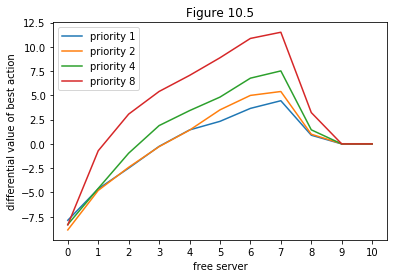

In [104]:
for priority in [1, 2, 4, 8]:
    plt.plot(range(11),\
             [np.dot(agent.state_action_function((priority, free), agent.select_action((priority,free), False)), agent.theta)\
              for free in range(11)], label='priority %d' %priority)
    
plt.legend()
plt.ylabel('differential value of best action')
plt.xlabel('free server')
plt.xticks(range(11))
plt.title('Figure 10.5')